In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
#
import pandas

In [4]:
def str2date(dt_str, verbose=0):
    try:
        return mpd.num2date(mpd.datestr2num(dt_str))
    except:
        if verbose:
            print('error date conversion: ', dt_str)
            #raise Exception('date conversion exception')
        #
        return None
#
def elapsed_time_2_num(tm_in):
    # guessing for now...
    tm_ins = tm_in.split('-')
    #
    if len(tm_ins)==0:
        return 0.
    if len(tm_ins)==1:
        days=0
        tm=tm_ins[0]
    if len(tm_ins)>1:
        days = tm_ins[0]
        tm = tm_ins[1]
    #
    h,m,s = tm.split(':')
    #
    return float(days)*24.*3600. + float(h)*3600. + float(m)*60. + float(s)
#
def running_mean(X, n=10):
    return (numpy.cumsum(X)[n:] - numpy.cumsum(X)[:-n])/n
#
#
# get header, print a few rows:
data_file_name = 'data/sacct_out.out'
#
# translation dictionary. Note the column input parameters (aka, --format=...) are not the same as
#.  the colunm names.
#
# with -p --delimiter='|', we get:
#. ['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End',
#'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', '']

types_dict={'User':str, 'JobID':str, 'JobName':str, 'Partition':str, 'State':str,
            'Timelimit':str,'Start':str2date, 'End':str2date, 'Elapsed':elapsed_time_2_num, 'MaxRSS':str,
            'MaxVMSize':str, 'NNodes':int, 'NCPUS':int}
delim = '|'

### HPC Usage data
- Presently focused on Mazama
- Usage data drawn via:
```
--format=User,JobID,Jobname,partition,state,time,start,end,elapsed,MaxRss,MaxVMSize,nnodes,ncpus
```
- Generally, type conversions will need to be performed manually
- But since we might change the columns of interest, let's code up a dictionary of functions to do the translation

In [5]:
#
with open(data_file_name, 'r') as fin:
    # NOTE: lines end with a delimiter, so dump the last value.
    #
    headers = fin.readline()[:-1].split(delim)
    delim_lines=fin.readline()
    #
    #print('*** headers: ', headers)
    #
    teasers = []
    for k in range(10):
        #print('**')
        #teasers += [fin.readline()[:-1].split()]
        teasers += [fin.readline()[:-2]]
#
print('headers: ', headers)
for k,rw in enumerate(teasers):
    print('{}: {}'.format(k,rw))

headers:  ['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', '']
0: |67.extern|extern||COMPLETED||2019-12-14T23:19:38|2019-12-14T23:19:42|00:00:04|0|107956K|1|2
1: |67.0|bash||COMPLETED||2019-12-14T23:19:38|2019-12-14T23:19:42|00:00:04|0|304272K|1|2
2: rmorsini|68|UOF_TES|suprib|FAILED|7-00:00:00|2019-12-14T23:20:20|2019-12-14T23:20:21|00:00:01|||10|200
3: |68.batch|batch||FAILED||2019-12-14T23:20:20|2019-12-14T23:20:21|00:00:01|0|169328K|1|48
4: |68.extern|extern||COMPLETED||2019-12-14T23:20:20|2019-12-14T23:20:21|00:00:01|0|107956K|10|200
5: rmorsini|69|bash|normal|COMPLETED|02:00:00|2019-12-14T23:25:27|2019-12-14T23:25:34|00:00:07|||1|2
6: |69.extern|extern||COMPLETED||2019-12-14T23:25:27|2019-12-14T23:25:34|00:00:07|0|107956K|1|2
7: |69.0|bash||COMPLETED||2019-12-14T23:25:27|2019-12-14T23:25:34|00:00:07|0|304272K|1|2
8: rmorsini|70|fish|normal|COMPLETED|02:00:00|2019-12-14T23:25:43|2019-12-14T23:25:55

In [6]:
#Read the whole data file:
#
#max_rows=1000
max_rows = None

#
with open(data_file_name, 'r') as fin:
    headers_rw = fin.readline()
    print('*** headers_rw: ', headers_rw)
    headers = headers_rw[:-1].split(delim)[:-1]
    RH = {h:k for k,h in enumerate(headers)}
    #
    delim_lines=fin.readline()
    #
    print('*** headers: ', headers)
    #
    #
    data = []
    for j,rw in enumerate(fin):
        if not (max_rows is None or max_rows<0) and j>max_rows:
            break
        
        #print('*** DEBUG: ', rw)
        data += [rw.split(delim)[:-1]]
        #print('* * DEBUG: ', data[-1])
        #
        for k, (col,vl) in enumerate(zip(headers, data[-1])):
            #print('j,k [{}:{}]: {}, {}'.format(col,vl, j,k))
            data[-1][k]=types_dict[col](vl)
        #
        #
#
print('** len: ', len(data))

*** headers_rw:  User|JobID|JobName|Partition|State|Timelimit|Start|End|Elapsed|MaxRSS|MaxVMSize|NNodes|NCPUS|

*** headers:  ['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS']
** len:  636366


In [7]:
data_df = pandas.DataFrame(data, columns=headers)

In [8]:
# unique completion states:
#
#states = sorted(list(set([rw[RH['State']]  for rw in data])))
states = sorted(list(set(data_df['State'])))
for s in states:
    print('** {}'.format(s))


** CANCELLED
** CANCELLED by 0
** CANCELLED by 1000
** CANCELLED by 20673
** CANCELLED by 256377
** CANCELLED by 274374
** CANCELLED by 274689
** CANCELLED by 274960
** CANCELLED by 276117
** CANCELLED by 280897
** CANCELLED by 292272
** CANCELLED by 293064
** CANCELLED by 311693
** CANCELLED by 311836
** CANCELLED by 312086
** CANCELLED by 312595
** CANCELLED by 313386
** CANCELLED by 324933
** CANCELLED by 328529
** CANCELLED by 331921
** CANCELLED by 331969
** CANCELLED by 351294
** CANCELLED by 362778
** CANCELLED by 52644
** CANCELLED by 528
** CANCELLED by 535
** CANCELLED by 543
** CANCELLED by 56352
** COMPLETED
** FAILED
** PENDING
** RUNNING
** TIMEOUT


In [9]:
#
### how 'bout a time series of sum(ncpu) RUNNING?
#
#ix = numpy.array([rw[RH['State']] in ['COMPLETED', 'RUNNING'] for rw in data])
ix = numpy.logical_or( data_df['State']=='COMPLETED', data_df['State']=='RUNNING')

# start_end_count = numpy.array([[mpd.mpd.datestr2num([rw[RH['Start']] for rw in data]),
#                                mpd.mpd.datestr2num([rw[RH['End']] for rw in data])],
#                               numpy.zeros(len(data))
                             
#                              )
#
t_now = mpd.date2num(dtm.datetime.now())
t_start = mpd.date2num([rw[RH['Start']] for rw in data if rw[RH['State']] in ['COMPLETED', 'RUNNING']])
t_end = numpy.array([mpd.date2num(rw[RH['End']]) if not rw[RH['End']] is None else t_now
                     for rw,b in zip(data, ix) if b==True])
n_cpu = numpy.array([rw[RH['NCPUS']]
                     for rw,b in zip(data, ix) if b==True])

#print('*** ', len(t_start), len(t_end), len(ix))

start_end = numpy.array([t_start, t_end]).T
#
# sort on t_start:
start_end = start_end[numpy.argsort(start_end[:,0])]

t_min = numpy.min(numpy.append(t_start, [x for x in t_end if not x is None] ))
t_max = numpy.max(numpy.append(t_start, [x for x in t_end if not x is None] ))
#
# can also create X sequence like, for minute resolution
# X = numpy.arange(t_min, t_max, 1./(24*60))
X = numpy.linspace(t_min, t_max, 10000)
#
Ns = numpy.zeros(len(X))
#
Ns_cpu = numpy.zeros(len(X))

In [10]:
# this is many 100's of times faster than its cousin below:
#Ns2 = numpy.zeros(len(X))
#
for j, (t_1, t_2, n) in enumerate(zip(t_start, t_end, n_cpu)):
    #if j%25000==0:
    #    print('j:: {}'.format(j))
    #
    # TODO: get more of the data set; compute the fraction of any job running turing this time
    #.
    Ns[numpy.logical_and( X>=t_1, X<t_2)] += 1
    Ns_cpu [numpy.logical_and( X>=t_1, X<t_2)] += n
    #

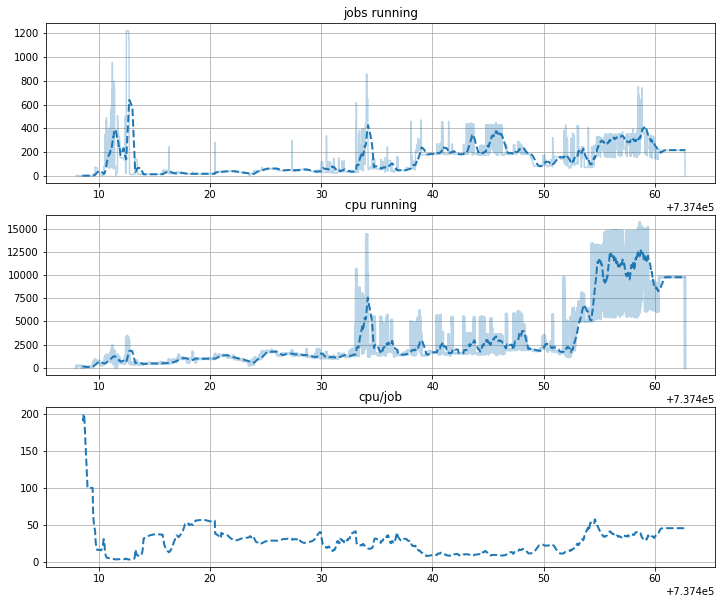

In [11]:
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('311')
ax2 = plt.subplot('312', sharex=ax1)
ax3 = plt.subplot('313', sharex=ax1)
n_ave = 100
#
ln, = ax1.plot(X,Ns, ls='-', lw=1.5, marker='', alpha=.3)
clr = ln.get_color()
#
Ns_sm = (numpy.cumsum(Ns)[n_ave:]-numpy.cumsum(Ns)[:-n_ave])/float(n_ave)
ax1.plot(X[n_ave:], Ns_sm, color=clr,
        ls='--', lw=2.)

ln, = ax2.plot(X, Ns_cpu, ls='-', lw=3., marker='', alpha=.3)
clr = ln.get_color()
Ns_cpu_sm = (numpy.cumsum(Ns_cpu)[n_ave:]-numpy.cumsum(Ns_cpu)[:-n_ave])/float(n_ave)
ax2.plot(X[n_ave:], Ns_cpu_sm, color=clr,
        ls='--', lw=2.)

ax3.plot(X[n_ave:], Ns_cpu_sm/Ns_sm, color=clr,
        ls='--', lw=2.)

#
ax1.set_title('jobs running')
ax2.set_title('cpu running')
ax3.set_title('cpu/job')
#
ax1.grid()
ax2.grid()
ax3.grid()

*** lens: 636366, 570300
[ 4.  4.  1.  1.  1.  7.  7.  7. 12. 12.]


/Users/myoder96/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0.99, 1.001)

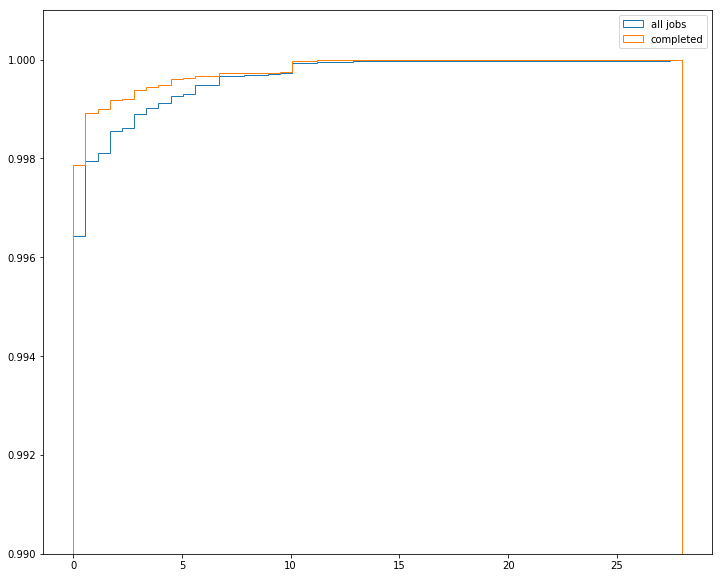

In [12]:

#
# delta_ts_all = numpy.array([elapsed_time_2_num(rw[RH['Elapsed']]) for rw in data])
# delta_ts_completed = numpy.array([elapsed_time_2_num(rw[RH['Elapsed']]) 
#                                   for rw in data if rw[RH['State']]=='COMPLETED'])
#
delta_ts_all = numpy.array([rw[RH['Elapsed']] for rw in data])
delta_ts_completed = numpy.array([rw[RH['Elapsed']] 
                                  for rw in data if rw[RH['State']]=='COMPLETED'])
#
print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
#
print(delta_ts_all[0:10])
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = True
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
                  label='all jobs')
hh_comp = ax.hist(delta_ts_completed*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                  label='completed')
#
ax.legend(loc=0)
#
ax.set_ylim(.99,1.001)

Text(0.5, 1.0, 'Cumulative Distribution of Job Lengths')

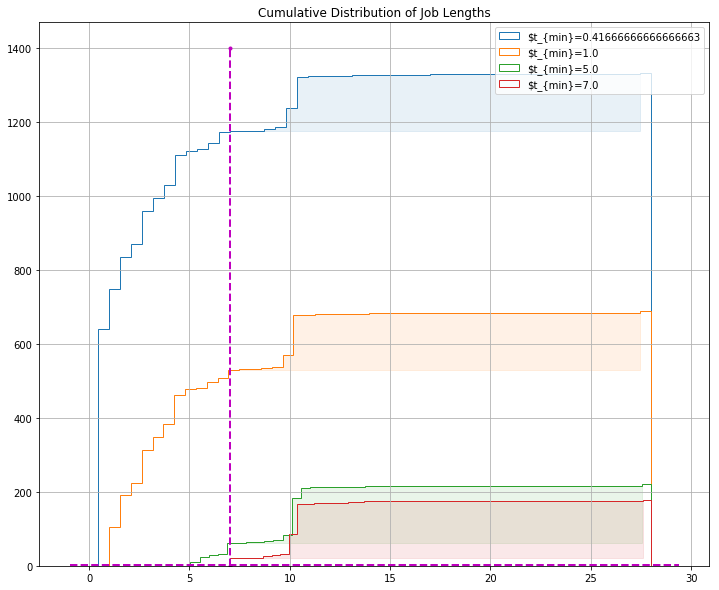

In [13]:
# time delayed plots. aka, probability (or counts) of job times given jobs > t_min
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = False
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
delta_ts_completed = numpy.array([rw[RH['Elapsed']]
                                      for rw in data if rw[RH['State']]=='COMPLETED'])
for k,t_min in enumerate([0., 3600., 36000., 24.*3600, 5.*24.*3600, 7.*24.*3600]):
    if k<2: continue

    #delta_ts_all = numpy.array([elapsed_time_2_num(rw[RH['Elapsed']]) for rw in data])
    
    #
    #print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
    #
    #print(delta_ts[0:10])
    #
    #
    #hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
    #                  label='all jobs')
    Y,X, patches = ax.hist(delta_ts_completed[delta_ts_completed>= t_min]*time_factor, bins=50,
                           log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                      label='$t_{{min}}={}'.format(t_min*time_factor,))
    #
    # fill bewteen (approximate) dt=7 intersection and y.
    k0 = numpy.argmin( (X-7.)**2. )
    y0 = Y[k0]
    clr = patches[0].get_edgecolor()
    ix = X[:-1]>7.
    #
    X_prime = [X[k0]]
    Y_prime = [Y[k0]]
    for j, (x,y1,y2) in enumerate(zip(X[k0+1:], Y[k0:-1], Y[k0+1:])):
        X_prime += [x, x]
        Y_prime += [y1, y2]
    #
    #ax.fill_between(numpy.array(X[:-1])[ix], y0, Y[ix], color=clr, alpha=.1)
    ax.fill_between(X_prime, y0, Y_prime, color=clr, alpha=.1)
    #print('** ** ', len(ax.lines))
    #
ax.legend(loc=0)
ax.grid()
ax.plot([7., 7.], ax.get_ylim(), marker='.', ls='--', lw=2., color='m')
ax.plot(ax.get_xlim(), [.9, .9], marker='', ls='--', lw=2., color='m')
#
ax.set_title('Cumulative Distribution of Job Lengths')

Text(0.5, 1.0, 'Cumulative Distribution of Usage-index ($\\Delta t \\cdot N_{cpu})')

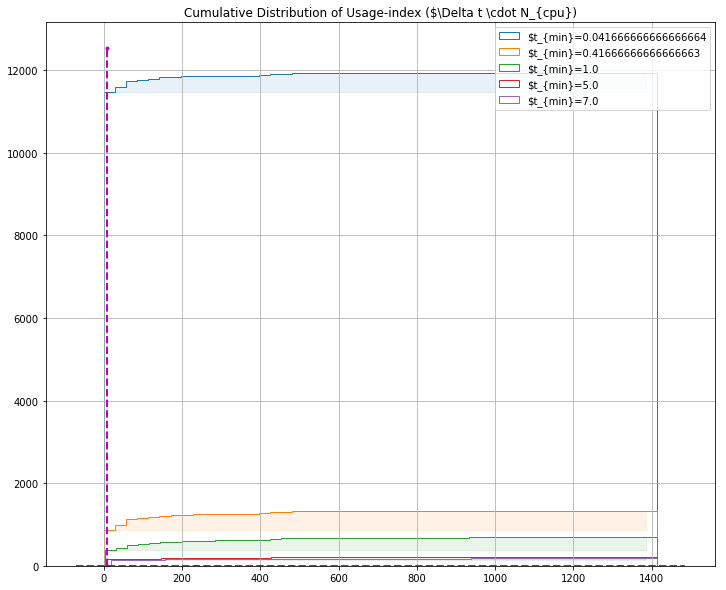

In [21]:
# time delayed plots. aka, probability (or counts) of job times given jobs > t_min
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = False
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
# usage index: dt*ncpus
usage_index_completed = numpy.array([rw[RH['Elapsed']]*float(rw[RH['NCPUS']])
                                      for rw in data if rw[RH['State']]=='COMPLETED'])
for k,t_min in enumerate([0., 3600., 36000., 24.*3600, 5.*24.*3600, 7.*24.*3600]):
    if k<1: continue

    #delta_ts_all = numpy.array([elapsed_time_2_num(rw[RH['Elapsed']]) for rw in data])
    
    #
    #print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
    #
    #print(delta_ts[0:10])
    #
    #
    #hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
    #                  label='all jobs')
    Y,X, patches = ax.hist(usage_index_completed[delta_ts_completed>= t_min]*time_factor, bins=50,
                           log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                      label='$t_{{min}}={}'.format(t_min*time_factor,))
    #
    # fill bewteen (approximate) dt=7 intersection and y.
    k0 = numpy.argmin( (X-7.)**2. )
    y0 = Y[k0]
    clr = patches[0].get_edgecolor()
    ix = X[:-1]>7.
    #
    X_prime = [X[k0]]
    Y_prime = [Y[k0]]
    for j, (x,y1,y2) in enumerate(zip(X[k0+1:], Y[k0:-1], Y[k0+1:])):
        X_prime += [x, x]
        Y_prime += [y1, y2]
    #
    #ax.fill_between(numpy.array(X[:-1])[ix], y0, Y[ix], color=clr, alpha=.1)
    ax.fill_between(X_prime, y0, Y_prime, color=clr, alpha=.1)
    #print('** ** ', len(ax.lines))
    #
ax.legend(loc=0)
ax.grid()
ax.plot([7., 7.], ax.get_ylim(), marker='.', ls='--', lw=2., color='m')
ax.plot(ax.get_xlim(), [.9, .9], marker='', ls='--', lw=2., color='m')
#
ax.set_title('Cumulative Distribution of Usage-index ($\Delta t \cdot N_{cpu})')

In [22]:
# How 'bout some data on long jobs...
#
long_jobs = [rw for rw in data if rw[RH['Elapsed']]>7*24.*3600]
#
long_jobs_df = data_df[data_df['Elapsed']>7*24.*3600]
#

In [24]:
# partitions using long jobs:
print("Long Job Partitons: ")
print("len: ", len(long_jobs))
print('partitions: ')
#for rw in list(set([s[RH['Partition']] for s in long_jobs])):
for rw in list(set(long_jobs_df['Partition'])):
    print('** ', rw)
    #
#
# partitions using long jobs:
print("Long Job Users: ")
print("len: ", len(long_jobs))
print('Users: ')
for rw in list(set(long_jobs_df['User'])):
    print('** ', rw)
    #
#

Long Job Partitons: 
len:  287
partitions: 
**  
**  beroza
**  ere
**  suckale
**  suprib
Long Job Users: 
len:  287
Users: 
**  
**  boelens
**  mengtang
**  zhipengq
**  retaille


In [17]:
print(headers)

['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End', 'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS']


In [18]:
total_compute_vol = numpy.sum(data_df['NCPUS']*data_df['Elapsed'])
ix = data_df['Elapsed']>(7.*24.*3600.)
long_compute_vol = numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix])
#
print('** jobs: ', len(data), len(data_df[ix]), sum(ix), len(data_df[ix])/len(data))
print('** compute tinme: ', numpy.sum(data_df['Elapsed']), numpy.sum(data_df['Elapsed'][ix]),
      numpy.sum(data_df['Elapsed'][ix])/numpy.sum(data_df['Elapsed']))
print('** compute volumnes: ', total_compute_vol, long_compute_vol, long_compute_vol/total_compute_vol)


** jobs:  636366 287 287 0.0004509983248633648
** compute tinme:  932868842.0 260761747.0 0.27952669792352225
** compute volumnes:  20256910939.0 4068918412.0 0.20086569093643186


Text(0.5, 0, 'Job length $t$ [days]')

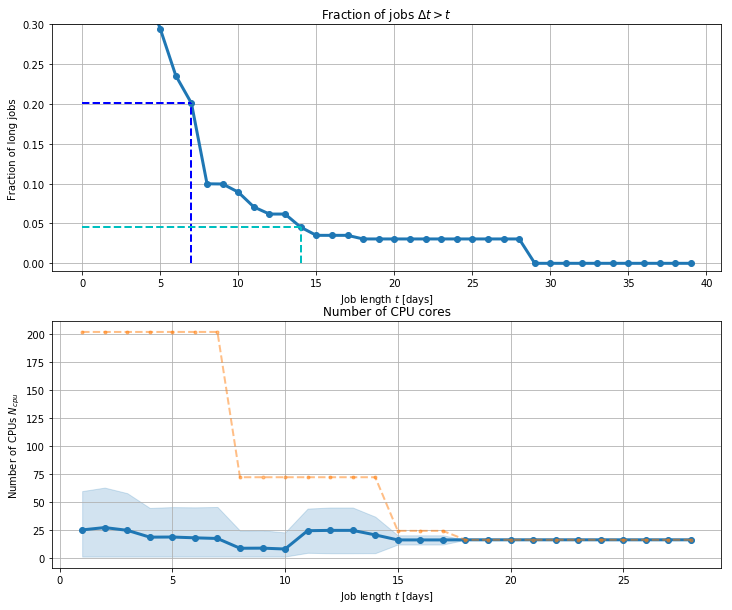

In [20]:
#
ts = numpy.arange(1,40)
lcvs = numpy.zeros(len(ts))
mean_n_cpus = numpy.zeros(len(ts))
stdev_n_cpus = numpy.zeros(len(ts))
max_n_cpus = numpy.zeros(len(ts))

for k,t in enumerate(ts):
    ix = data_df['Elapsed']>(t*24.*3600.)
    lcv = numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix])
    #
    lcvs[k] = numpy.sum(numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix]))/total_compute_vol
    #
    mean_n_cpus[k]  = numpy.mean(data_df['NCPUS'][ix])
    stdev_n_cpus[k] = numpy.std(data_df['NCPUS'][ix])
    max_n_cpus[k] = numpy.max(data_df['NCPUS'][ix])
    #
#
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax1.grid()
ax2 = plt.subplot('212')
ax2.grid()
#
ax1.plot(ts, lcvs, ls='-', marker='o', lw=3)
ln, ax2.plot(ts, mean_n_cpus, ls='-', marker='o', lw=3)
clr = ln.get_color()
ax2.fill_between(ts, numpy.max([numpy.ones(len(ts)), mean_n_cpus-stdev_n_cpus], axis=0), mean_n_cpus+stdev_n_cpus, alpha=.2, color=clr)
ax2.plot(ts, max_n_cpus, ls='--', marker='.', lw=2., alpha=.5)
#
#
n = 7
ax1.plot([0., n], [lcvs[n-1], lcvs[n-1]], ls='--', lw=2., color='b')
ax1.plot([n, n], [0., lcvs[n-1]], ls='--', lw=2., color='b')
#
n=14
ax1.plot([0., n], [lcvs[n-1], lcvs[n-1]], ls='--', lw=2., color='c')
ax1.plot([n, n], [0., lcvs[n-1]], ls='--', lw=2., color='c')
#
ax1.set_ylim(-.01, .3)
#
ax1.set_title('Fraction of jobs $\Delta t > t$')
ax1.set_ylabel('Fraction of long jobs')
ax1.set_xlabel('Job length $t$ [days]')

ax2.set_title('Number of CPU cores')
ax2.set_ylabel('Number of CPUs $N_{cpu}$')
ax2.set_xlabel('Job length $t$ [days]')

